<a href="https://colab.research.google.com/github/MalenaGlez/TFG-CNN-Resonancias/blob/main/Modelo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importaciones
import shutil
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix


Se fija una semilla para que los resultados sean reproducibles:

In [ ]:
semilla = 13

np.random.seed(semilla)
random.seed(semilla)
tf.random.set_seed(semilla)
os.environ['PYTHONHASHSEED'] = str(semilla)

# Hacer deterministas las operaciones
tf.keras.utils.set_random_seed(semilla)
tf.config.experimental.enable_op_determinism()

Rutas de los datos ya procesados, es decir, ya están divididos en train, test y val, y además las imágenes están redimensionadas. Esto se ha hecho en DataPreparation.ipynb

In [ ]:
#Rutas de los datos ya procesados:
processed_dir = '/content/drive/My Drive/processed_data'
train_dir = os.path.join(processed_dir, 'train')
test_dir = os.path.join(processed_dir, 'test')
val_dir = os.path.join(processed_dir, 'val')

In [ ]:
clases = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
print(clases)

['alzheimers_dataset', 'normal', 'parkinsons_dataset']


De esta forma podemos saber que el programa tratará a las clases como:


*   Clase 0 : Alzheimer
*   Clase 1 : Normal
*   Clase 2 : Parkinson








Con la siguiente función se preparan los datos como arrays numéricos normalizados para ser usados por el modelo de Keras:

In [ ]:
def preparation_images(source):
    """
    source : carpeta de imágenes que se quiere preparar. En esta carpeta
    debe haber subcarpetas con las imágenes de cada clase.

    Returns
    Esta función devuelve un vector x con las imagénes normalizadas a [0,1],
    con forma (224,224,1), es decir, con dimensión 224x224 y esacala de grises (1).
    Por otro lado, devuelve un vector y con las etiquetas de cada clase (0,1,2).

    """
    x = [] # contiene las entradas, que en este caso son imágenes
    y = [] # contiene las etiquetas correspondientes a cada imagen (0, 1 o 2)

    for label, class_name in enumerate(clases):
        ruta_clase = os.path.join(source, class_name)

        # Si la carpeta no existe, se la salta
        if not os.path.isdir(ruta_clase):
            continue

        # Por cada imagen de la ruta_clase, se carga la imagen
        for filename in os.listdir(ruta_clase):

            # Se comprueba el formato
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(ruta_clase, filename)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:

                    # Normalizamos las imágenes a escala [0,1]
                    img = img.astype('float32') / 255.0

                    # Adaptamos su forma
                    img = np.expand_dims(img, axis=-1)  # (224, 224) -> (224, 224, 1)
                    x.append(img)
                    y.append(label)

    return np.array(x), np.array(y), clases


Aplicamos la función anterior a cada conjunto de datos que va a ser usardo en el modelo:

In [ ]:
x_train, y_train, class_names = preparation_images(train_dir)
x_test, y_test, _ = preparation_images(test_dir)
x_val, y_val, _ = preparation_images(val_dir)

# Configuración del entrenamiento

1.   Creamos el modelo de red neuronal convolucional, compuesto por:
      *   Tres bloques convolucionales.
      *   Una capa densa y otra capa de salida.
2.   Parada temprana mediante EarlyStopping:
      *   Detiene el entrenamiento si durante 5 épocas no hay mejora en la pérdida de validación.
3.   Compilamos el modelo:
      *   Como optimizador para los pesos usamos 'adam', explicado en teoría.
      *   La función de pérdida es 'sparse_categorical_crossentropy' porque las etiquetas creadas por 'preparation_images' son enteros (0, 1 o 2).













In [ ]:
modelo = Sequential([
    Input(shape=(224, 224, 1)),
    Conv2D(32, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = (2, 2)),

    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = (2, 2)),

    Conv2D(128, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size = (2, 2)),

    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),

    Dense(3, activation = 'softmax')
])

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,         # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights = True  # Restaura los mejores pesos que se han encontrado
)

modelo.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',  # Usamos etiquetas como enteros (0, 1, 2)
    metrics = ['accuracy']
)

# Entrenamiento del modelo
Entrenamos el modelo anterior durante, como máximo, 30 épocas y con un tamaño de batch de 32.


In [ ]:
print("Comenzanzo entrenamiento")
historial = modelo.fit(
    x_train, y_train,
    epochs = 30,            # Cuántas veces pasa por todos los datos
    batch_size = 32,        # Número de imágenes usadas por paso de entrenamiento
    validation_data = (x_val, y_val),
    callbacks = [early_stopping],
    shuffle = True          # De esta forma el modelo no aprende patrones basados
                          # en el orden de los datos
)
print("Entrenamiento terminado")

Comenzanzo entrenamiento
Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - accuracy: 0.6594 - loss: 2.9624 - val_accuracy: 0.3155 - val_loss: 2.4409
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.8366 - loss: 0.3414 - val_accuracy: 0.5031 - val_loss: 1.2829
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.8657 - loss: 0.2879 - val_accuracy: 0.8484 - val_loss: 0.3467
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.8870 - loss: 0.2530 - val_accuracy: 0.8975 - val_loss: 0.2404
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9142 - loss: 0.2095 - val_accuracy: 0.9141 - val_loss: 0.1915
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9323 - loss: 0.1743 - val_accuracy: 0.9229 - val_loss: 0.1937
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9373 - loss: 0.1641 - val_accuracy: 0.9413 - val_loss: 0.1573
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - a

# Evaluación del modelo
Evaluamos el modelo entrenado en un conjunto de datos que no ha sido visto durante el entrenamiento, el conjunto test.

In [ ]:
evaluation = modelo.evaluate(x_test, y_test)
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')
print(f'Pérdida: {evaluation[0]:.2f}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9403 - loss: 0.1357
Test Accuracy: 95.95%
Pérdida: 0.10


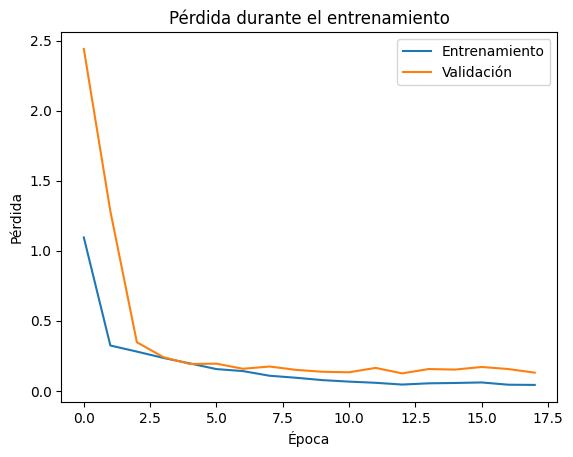

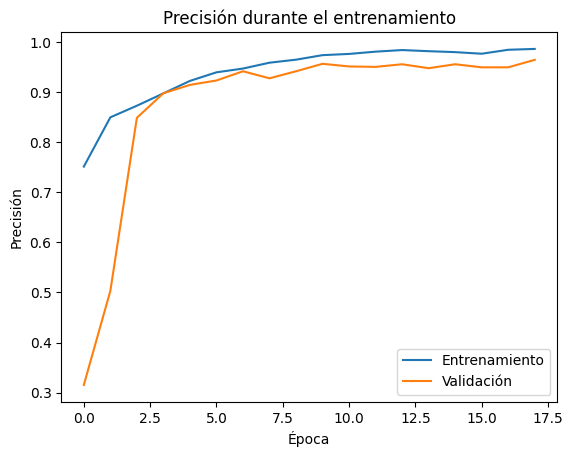

In [ ]:
# Pérdida (loss)
plt.plot(historial.history['loss'], label='Entrenamiento')
plt.plot(historial.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Accuracy
plt.plot(historial.history['accuracy'], label='Entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()


# Métricas
1.   Calculamos las probabilidades de que cada elemento de x_test pertenezca a cada clase (y_pred_probs).
1.   Después se toma para cada valor el argumento máximo, convirtiéndose en la clase predicha (y_pred).
2.   Por último, calculamos la matriz de confusión comparando lo que se ha obtenido al predecir (y_pred) y lo que realmente es (y_test).






In [ ]:
y_pred_probs = modelo.predict(x_test)     # Probabilidades
y_pred = np.argmax(y_pred_probs, axis=1)  # Clase predicha

# Matriz de confusión
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
print(cm)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Confusion Matrix
[[346  29   0]
 [ 30 373   1]
 [  0   2 356]]


In [ ]:
# Informe de clasificación
print(classification_report(y_test, y_pred, target_names=clases))

                    precision    recall  f1-score   support

alzheimers_dataset       0.92      0.92      0.92       375
            normal       0.92      0.92      0.92       404
parkinsons_dataset       1.00      0.99      1.00       358

          accuracy                           0.95      1137
         macro avg       0.95      0.95      0.95      1137
      weighted avg       0.95      0.95      0.95      1137



Otra forma de calcular las métricas de forma manual:

In [ ]:
VP1=cm[0,0]
VP2=cm[1,1]
VP3=cm[2,2]
VP=[VP1,VP2,VP3]

#Total reales por clase (suma filas)
total_real = np.sum(cm, axis=1)
# Total predichos por clase (suma columnas)
total_pred = np.sum(cm, axis=0)
suma_total = np.sum(cm)

#Métricas
Accuracy = (VP1+VP2+VP3)/suma_total
Tasa_error = 1-Accuracy
precision = VP / total_pred
recall = VP / total_real
f1 = 2 * (precision * recall) / (precision + recall)

In [ ]:
print(f"Accuracy: {Accuracy:.3f}")
print(f"Tasa de error: {Tasa_error:.3f}")
for i in range(len(VP)):
    print(f"Clase {i}:")
    print(f"  Precisión: {precision[i]:.3f}")
    print(f"  Recall:    {recall[i]:.3f}")
    print(f"  F1-score:  {f1[i]:.3f}")


Accuracy: 0.945
Tasa de error: 0.055
Clase 0:
  Precisión: 0.920
  Recall:    0.923
  F1-score:  0.921
Clase 1:
  Precisión: 0.923
  Recall:    0.923
  F1-score:  0.923
Clase 2:
  Precisión: 0.997
  Recall:    0.994
  F1-score:  0.996
